In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CTCLoss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math

# Load data

In [2]:
train = pd.read_csv('/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/handwriting-recognition/written_name_test_v2.csv')

In [3]:
train_img_dir = '/handwriting-recognition/train_v2/train/'
val_img_dir = '/handwriting-recognition/validation_v2/validation/'
test_img_dir = '/handwriting-recognition/test_v2/test'

# View & Clean data

## Overview

In [4]:
train.head(6)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
5,TRAIN_00006.jpg,LUCIE


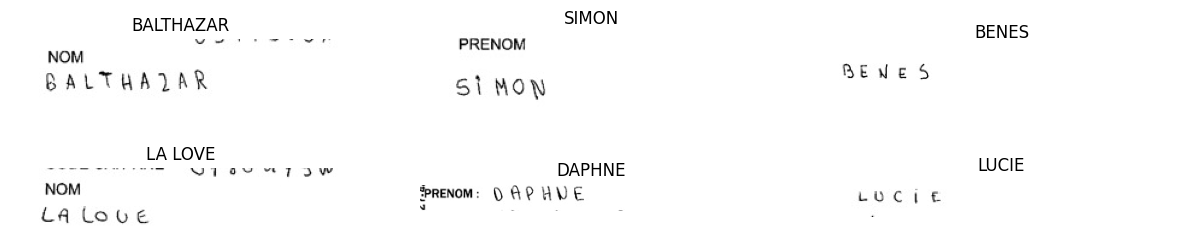

In [5]:
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = train_img_dir +train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Missing value

In [6]:
print(f"Training set missing values: {train['IDENTITY'].isnull().sum()}")
print(f"Validation set missing values: {valid['IDENTITY'].isnull().sum()}")

Training set missing values: 565
Validation set missing values: 78


In [7]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

## Special value

In [8]:
train['IDENTITY'].value_counts()

IDENTITY
THOMAS        1825
EMPTY         1796
LEA           1582
EMMA          1482
LUCAS         1479
              ... 
DOUY             1
LE-MIGNANT       1
ENJILELA         1
ALIY             1
LEDOIT           1
Name: count, Length: 100539, dtype: int64

In [9]:
print(f"Number of unreadable images: {train[train['IDENTITY'] == 'UNREADABLE'].value_counts().sum()}")
print(f"Number of empty images: {train[train['IDENTITY'] == 'EMPTY'].value_counts().sum()}")
lowercase_count = train[train['IDENTITY'].str.contains(r'[a-z]', regex=True)].shape[0]
print(f"Number of labels with lowercase: {lowercase_count}")

Number of unreadable images: 102
Number of empty images: 1796
Number of labels with lowercase: 17


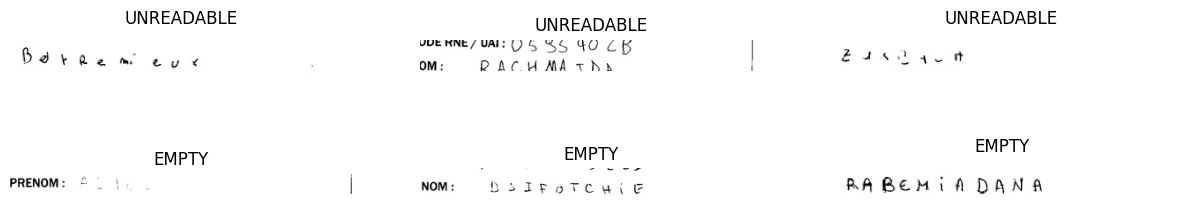

In [10]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
empty = train[train['IDENTITY'] == 'EMPTY']

unreadable.reset_index(inplace=True, drop=True)
empty.reset_index(inplace=True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(3):
    # Plot unreadable images
    ax = plt.subplot(2, 3, i+1)
    img_dir = train_img_dir + unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

    # Plot empty images
    ax = plt.subplot(2, 3, i+4)
    img_dir = train_img_dir + empty.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    plt.title(empty.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [11]:
train = train[train['IDENTITY'] != 'UNREADABLE']
train = train[train['IDENTITY'] != 'EMPTY']
train['IDENTITY'] = train['IDENTITY'].str.upper()
train.reset_index(inplace = True, drop=True) 

In [12]:
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'EMPTY']
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
valid.reset_index(inplace = True, drop=True)

# Custom dataset

In [13]:
class dataset(Dataset):
    def __init__(self, img_dir, filenames, labels, transform=None):
        self.img_dir = img_dir
        self.filenames = filenames
        self.labels = labels
        self.transform = transform
        self.alphabet = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-'` "
        self.char_to_idx = {char: idx + 1 for idx, char in enumerate(self.alphabet)}
        self.char_to_idx['<BLANK>'] = 0

    def __len__(self):
        return len(self.filenames)
    
    def encode_label(self, label):
        return [self.char_to_idx[char] for char in label]
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.filenames[idx])
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        label_encoded = self.encode_label(label)
        label_length = len(label_encoded)

        return image, torch.tensor(label_encoded, dtype=torch.long), torch.tensor(label_length, dtype=torch.long)

In [14]:
class PreprocessTransform:
    def __call__(self, img):
        img = np.array(img)
        (h, w) = img.shape
        final_img = np.ones([64, 256]) * 255  # blank white image

        # crop
        if w > 256:
            img = img[:, :256]

        if h > 64:
            img = img[:64, :]

        final_img[:h, :w] = img
        final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
        
        # Convert to PyTorch tensor and normalize to [0, 1]
        final_img = torch.tensor(final_img, dtype=torch.float32) / 255.0
        final_img = final_img.unsqueeze(0)  # Add channel dimension

        return final_img
transform = PreprocessTransform()

In [15]:
# Collate function to handle variable-length sequences
def collate_fn(batch):
    images, labels, label_lengths = zip(*batch)
    
    # Pad the labels
    max_length = max([len(label) for label in labels])
    padded_labels = torch.zeros(len(labels), max_length, dtype=torch.long)
    
    for i, label in enumerate(labels):
        padded_labels[i, :len(label)] = label
    
    images = torch.stack(images, 0)
    label_lengths = torch.stack(label_lengths, 0)
    
    return images, padded_labels, label_lengths

In [16]:
len(train)

328498

In [17]:
train_size = int(len(train))
train_dataset = dataset(train_img_dir, train['FILENAME'].head(train_size).values, train['IDENTITY'].head(train_size).values, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=3, collate_fn=collate_fn)

# Model

In [18]:
class CNNtoRNN(nn.Module):
    def __init__(self,num_of_characters):
        super(CNNtoRNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # (3, 3) kernel, 'same' padding
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Max pooling layers
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # (2, 2) kernel
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # (2, 2) kernel
        self.maxpool3 = nn.MaxPool2d(kernel_size=(1, 2))  # (1, 2) kernel
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 8, 64)  # input features = 128 * 8
        
        # Bidirectional LSTM layers
        self.lstm1 = nn.LSTM(64, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        
        num_of_characters = 31 
        self.fc2 = nn.Linear(512, num_of_characters)
   
    def forward(self, x, check_shape= False):
        # Convolution + BatchNorm + ReLU + MaxPool
        x = self.maxpool1(F.relu(self.bn1(self.conv1(x))))
        if check_shape:
            print(f'After conv1: {x.shape}')
        x = self.maxpool2(F.relu(self.bn2(self.conv2(x))))
        if check_shape:
            print(f'After conv2: {x.shape}')     
        x = self.dropout1(x)
        x = self.maxpool3(F.relu(self.bn3(self.conv3(x))))
        if check_shape:
            print(f'After conv3: {x.shape}')
        x = self.dropout2(x)
        # Reshape from (batch, channels, height, width) to (batch, height, channels * width)
        batch, channels, height, width = x.size()
        x = x.permute(0, 2, 1, 3).contiguous().view(batch, height, channels * width)
        if check_shape:
            print(f'After reshape: {x.shape}')   
        # Fully connected layer
        x = F.relu(self.fc1(x))
        if check_shape:
            print(f'After fc1: {x.shape}')
        # Bidirectional LSTM layers
        x, _ = self.lstm1(x)
        if check_shape:
            print(f'After lstm1: {x.shape}')
        x, _ = self.lstm2(x)
        if check_shape:
            print(f'After lstm2: {x.shape}')
        # Output layer
        x = self.fc2(x)
        x = F.log_softmax(x, dim=2)
        if check_shape:
            print(f'After fc2 (log_softmax): {x.shape}')
        return x

# Example usage
num_of_characters = 31  # Number of possible characters
model = CNNtoRNN(num_of_characters)

# Create a random tensor with the shape of your input data
input_tensor = torch.randn(1, 1, 256, 64)  # (batch_size, channels, height, width)

# Forward pass to print the shape of each layer's output
output = model(input_tensor, check_shape= True)

After conv1: torch.Size([1, 32, 128, 32])
After conv2: torch.Size([1, 64, 64, 16])
After conv3: torch.Size([1, 128, 64, 8])
After reshape: torch.Size([1, 64, 1024])
After fc1: torch.Size([1, 64, 64])
After lstm1: torch.Size([1, 64, 512])
After lstm2: torch.Size([1, 64, 512])
After fc2 (log_softmax): torch.Size([1, 64, 31])


In [19]:
# Test with a dummy input
dummy_input = torch.randn(1 , 1, 256, 64)
output = model(dummy_input)
print("Final output shape: ", output.shape)

Final output shape:  torch.Size([1, 64, 31])


In [20]:
# pretrain_path = "/kaggle/input/pretrain_crnn/pytorch/65-80-epoch/1/model_80.pth"
# model = torch.load(pretrain_path)
num_of_characters = 31  # Number of possible characters
model = CNNtoRNN(num_of_characters)

In [21]:
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu'
model.to(device)

CNNtoRNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (lstm1): LSTM(64, 256, batch_first=True, bidirectional=True)
 

In [22]:
num_epochs = 60
lr = 0.0001

# Define the loss function and optimizer
criterion = nn.CTCLoss(blank=0,zero_infinity=True)  # 0 is the index for the CTC blank label
optimizer = optim.Adam(model.parameters(), lr=lr)

def calculate_input_lengths(outputs, labels):
    # Calculate the lengths of the inputs and labels
    input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    return input_lengths, label_lengths

for epoch in range(num_epochs):
    model.train()
    for batch_idx, (images, labels, label_lengths) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)
        
        input_lengths, label_lengths = calculate_input_lengths(outputs, labels)
        
        loss = criterion(outputs, labels, input_lengths, label_lengths)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        
        if (batch_idx % 100 == 0): #and not ((math.isnan(loss.item()) or math.isinf(loss.item()))):
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item()}')
            if (math.isnan(loss.item()) or math.isinf(loss.item())):
                break
            else:
                save_path = f"/working/model_{epoch+1}.pth"
                torch.save(model, save_path)
    if (math.isnan(loss.item()) or math.isinf(loss.item())):
        break        
print("Training complete.")

Epoch 1/60, Batch 0/321, Loss: -1.9128532409667969
Epoch 1/60, Batch 100/321, Loss: -1.9339630603790283
Epoch 1/60, Batch 200/321, Loss: -1.9750087261199951
Epoch 1/60, Batch 300/321, Loss: -1.86127507686615
Epoch 2/60, Batch 0/321, Loss: -1.7147705554962158
Epoch 2/60, Batch 100/321, Loss: -1.9256774187088013
Epoch 2/60, Batch 200/321, Loss: -1.9118766784667969
Epoch 2/60, Batch 300/321, Loss: -1.8599035739898682
Epoch 3/60, Batch 0/321, Loss: -2.010040521621704
Epoch 3/60, Batch 100/321, Loss: -2.020090341567993
Epoch 3/60, Batch 200/321, Loss: -1.9491411447525024
Epoch 3/60, Batch 300/321, Loss: -1.8706445693969727
Epoch 4/60, Batch 0/321, Loss: -1.9444971084594727
Epoch 4/60, Batch 100/321, Loss: -1.5495089292526245
Epoch 4/60, Batch 200/321, Loss: -1.8609428405761719
Epoch 4/60, Batch 300/321, Loss: -1.8622806072235107
Epoch 5/60, Batch 0/321, Loss: -1.9977695941925049
Epoch 5/60, Batch 100/321, Loss: -1.9356012344360352
Epoch 5/60, Batch 200/321, Loss: -1.9878394603729248
Epoch 5

# Plot some predictions

In [23]:
# Decoding function
def greedy_decoder(output, labels):
    output = output.cpu().numpy()
    arg_maxes = np.argmax(output, axis=2)
    decodes = []
    for i in range(arg_maxes.shape[1]):
        args = arg_maxes[:, i]
        decode = []
        for j in range(args.shape[0]):
            index = args[j]
            if index != 0:
                decode.append(labels[index])
        decodes.append(decode)
    return decodes

labels = ['<BLANK>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '-', "'", '`', ' ']

In [24]:
infer_size = 25
# Prepare the inference DataLoader
inference_dataset = dataset(test_img_dir, test['FILENAME'].head(infer_size).values, test['IDENTITY'].head(infer_size).values, transform=transform)
inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

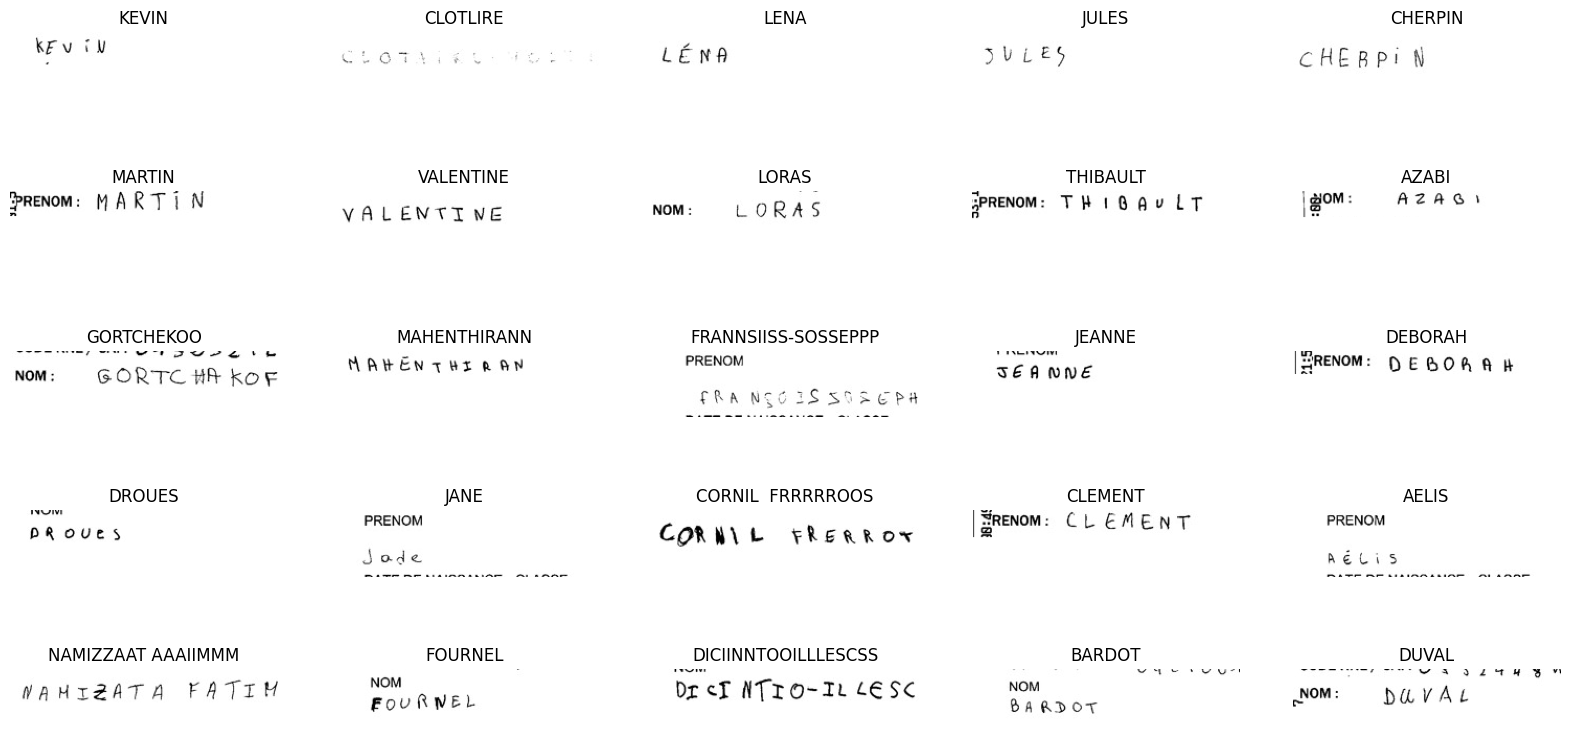

In [25]:
model.to(device)
model.eval()

results = []
for images, _, _ in inference_loader:
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)  # Shape should be (seq_len, batch, num_of_characters)
        outputs = F.log_softmax(outputs, dim=2)
        decoded_output = greedy_decoder(outputs, labels)
        results.append((images.cpu().squeeze().numpy(), ''.join(decoded_output[0])))

# Plot the results
def plot_results(results):
    plt.figure(figsize=(20, 10))
    for i, (image, prediction) in enumerate(results):
        plt.subplot(5, 5, i + 1)  # Adjust subplot size according to number of results
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        plt.imshow(image, cmap='gray')
        plt.title(prediction)
        plt.axis('off')
    plt.show()

# Show the first 25 results
plot_results(results[:25])

# Evaluate on validate set

In [26]:
# Function to calculate character-level accuracy
def character_level_accuracy(preds, targets):
    correct_characters = 0
    total_characters = 0
    for pred, target in zip(preds, targets):
        total_characters += len(target)
        correct_characters += sum(p == t for p, t in zip(pred, target))
    accuracy = correct_characters / total_characters if total_characters > 0 else 0
    return accuracy * 100

# Function to calculate word-level accuracy
def word_level_accuracy(preds, targets):
    correct_words = sum(p == t for p, t in zip(preds, targets))
    total_words = len(targets)
    accuracy = correct_words / total_words if total_words > 0 else 0
    return accuracy * 100

In [27]:
len(valid)

41093

In [28]:
# Prepare the val DataLoader
val_size = int(len(valid))
validation_dataset = dataset(val_img_dir, valid['FILENAME'].head(val_size).values, valid['IDENTITY'].head(val_size).values, transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [29]:
# Evaluate on validation set
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for images, targets, _ in validation_loader:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)  # Shape should be (seq_len, batch, num_of_characters)
        outputs = F.log_softmax(outputs, dim=2)
        decoded_output = greedy_decoder(outputs, labels)
        
        # Ensure targets are in the correct format
        target_strings = []
        for target in targets:
            if isinstance(target, torch.Tensor):
                idx = target[torch.nonzero(target)]
#                 print(idx.reshape(-1).tolist())
                target_strings.append(''.join([labels[x] for x in idx]))
            else:
                target_strings.append(''.join([labels[char] for char in target if char != 0]))
        
        all_predictions.extend([''.join(dec) for dec in decoded_output])
        all_targets.extend(target_strings)

char_accuracy = character_level_accuracy(all_predictions, all_targets)
word_accuracy = word_level_accuracy(all_predictions, all_targets)

print(f'Correct characters predicted : {char_accuracy:.2f}%')
print(f'Correct words predicted      : {word_accuracy:.2f}%')

Correct characters predicted : 91.15%
Correct words predicted      : 78.98%


# Evaluate on test set

In [30]:
test.dropna(axis=0, inplace=True)
test = test[test['IDENTITY'] != 'UNREADABLE']
test = test[test['IDENTITY'] != 'EMPTY']
test['IDENTITY'] = test['IDENTITY'].str.upper()
test.reset_index(inplace = True, drop=True)

In [31]:
len(test)

41068

In [32]:
# Prepare the test DataLoader
test_size = int(len(test))
test_dataset = dataset(test_img_dir, test['FILENAME'].head(test_size).values, test['IDENTITY'].head(test_size).values, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [33]:
# Evaluate on test set
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for images, targets, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)  # Shape should be (seq_len, batch, num_of_characters)
        outputs = F.log_softmax(outputs, dim=2)
        decoded_output = greedy_decoder(outputs, labels)
        
        # Ensure targets are in the correct format
        target_strings = []
        for target in targets:
            if isinstance(target, torch.Tensor):
                idx = target[torch.nonzero(target)]
#                 print(idx.reshape(-1).tolist())
                target_strings.append(''.join([labels[x] for x in idx]))
            else:
                target_strings.append(''.join([labels[char] for char in target if char != 0]))
        
        all_predictions.extend([''.join(dec) for dec in decoded_output])
        all_targets.extend(target_strings)

char_accuracy = character_level_accuracy(all_predictions, all_targets)
word_accuracy = word_level_accuracy(all_predictions, all_targets)

print(f'Correct characters predicted : {char_accuracy:.2f}%')
print(f'Correct words predicted      : {word_accuracy:.2f}%')

Correct characters predicted : 91.04%
Correct words predicted      : 78.55%
